## **Perfil Consumidor - CETAX Consultoria**

### Importando as bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from fbprophet import Prophet
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import googlemaps
import time
import pickle

###  Função distance
Função para acessar o API do Google MAPS e retirar a distância em metros entre dois endereços distintos.

In [2]:
"""Function that calculates the distance between origen and destino
    Parameters:
    -----------
    Inputs:
        origem (str): 
        destino (str):
    Return:
        distance (float): distance between origem and destino, given by the maps API
    """
#gmaps = googlemaps.Client(key='DIGITE A SUA KEY')
def distance(origem, destino):  
    distance_result = gmaps.distance_matrix(origins=origem,
                                        destinations=destino,
                                        mode='walking', units='metric')
    if (distance_result['rows'][0]['elements'][0]['status'] == 'NOT_FOUND'):
        return 0
    else:
        return distance_result['rows'][0]['elements'][0]['distance']['value']

### Pre-Processing the Dataset
<p align="justify">Tratamento inicial do dataset, onde será retirado dados de clientes duplicados, calcular a idade dos clientes a partir da data de nascimento, retirar variáveis que possuem mais de 50% dos dados incompletos(NaN), variáveis de data e também variáveis que possuem o mesmo valor para mais de 75% dos dados.</p>

In [3]:
# Importando o dataset
dataset = pd.read_excel('regs.xlsx')

# Retirando dados duplicados
dataset.drop_duplicates(subset='SKASSOCIADO', inplace=True)
dataset.drop_duplicates(inplace=True)

# Tratando idade a partir da data de nascimento
idade = pd.DataFrame()
idade['Data'] = dataset.DTNASCTL
idade['Ano'] = idade.Data.replace('.*/.*/(.*)', value=r'\1', regex=True).astype(int)
idade['Idade'] = 117 - idade.Ano

# Retirando variáveis com mais de 50% dos dados incompletos
for var in dataset:
    if(dataset[var].isnull().sum() + len(dataset[var].loc[dataset[var].astype(str) == ' ']) > 3000):
        dataset.drop(var, axis=1, inplace=True)


# Retirando variaveis onde mais de 75% dos dados possuem mesmo valor
for var in dataset:
    for i in dataset[var].value_counts():
        if(i>4500):
            dataset.drop(var, axis=1, inplace=True)
    
# Retirando variáveis de data
for var in dataset:
    if (re.match('SKDT', var)):
        dataset.drop(var, axis=1, inplace=True)
    elif (re.match('DT', var)):
        dataset.drop(var, axis=1, inplace=True)
        

### **Feature Extraction**
Retirando do dataset as features que serão utilizadas na clusterização.

In [4]:
# Criando dataframe com as features que serão utilizadas
dtrain = pd.DataFrame()
dtrain['END_Cliente'] = dataset.NRENDERE.astype(str) + ', ' + dataset.DSENDERE + ', ' + dataset.NMBAIRRO_2+ ', ' + dataset.NMCIDADE_2
dtrain['END_Agencia'] = dataset.NRENDCOP.astype(str) + ', ' + dataset.DSENDCOP + ', ' + dataset.NMBAIRRO+ ', ' + dataset.NMCIDADE
dtrain['Seguro'] = dataset.DSSEGURO
dtrain['ValorSEG'] = dataset.VLPRESEG
dtrain['Renda'] = dataset.VL_RENDA_FATANUAL
dtrain['Idade'] = idade.Idade
dtrain['GrupoRenda'] = dataset.DSGRUPORENDAFAT

# Mapeando renda por grupo
renda = dtrain.GrupoRenda.value_counts()
for i in range(2,7):
    renda[i-2] = i
renda[5] = 1
renda[6] = 7
renda[7] = 0
dtrain.GrupoRenda = dtrain.GrupoRenda.map(renda)

# Mapeando idade por grupo
dtrain['GrupoIdade'] = dtrain.Idade
def age_group(idade):
    if idade<30:
        return 0
    elif idade<45:
        return 1
    elif idade<60:
        return 2
    elif idade<80:
        return 3
    else:
        return 4
dtrain.GrupoIdade = dtrain.GrupoIdade.apply(age_group)

# Tratamento da distância entre o endereço do cliente e da agência em que abriu o seguro

''' USO DO API DO GOOGLE MAPS PARA PEGAR A DISTANCIA ENTRE OS ENDEREÇOS,
    APÓS A PRIMEIRA EXTRAÇÃO, OS DADOS FORAM GRAVADOS EM UM ARQUIVO PICKLE PARA EVITAR REALIZAR AS MESMAS
    REQUISIÇÕES NO API NOVAMENTE
    
dtrain['Distancia'] = np.ones((5390,1))
for i in dtrain.index:
    dtrain['Distancia'][d[i]] = distance(origem=dtrain['END_Cliente'][d[i]],destino=dtrain['END_Agencia'][d[i]])

output = open('distancia.pickle', 'wb')
pickle.dump(dtrain['Distancia'], output)
output.close()

dtrain.Distancia.loc[dtrain.Distancia == 0] = np.NaN
dtrain.Distancia = dtrain.Distancia.fillna(dtrain.Distancia.mean())
'''
f = open('distancia.pickle', 'rb')
dtrain['Distancia'] = pickle.load(f)
f.close()

dtrain.drop(['END_Cliente','END_Agencia','Idade','Renda'], axis=1, inplace=True)

In [5]:
print(dtrain.head(10))
print(dtrain.dtypes)

         Seguro  ValorSEG  GrupoRenda  GrupoIdade  Distancia
0          CASA     31.22           4           2     5600.0
1          CASA     24.38           5           3     5716.0
2          VIDA      9.56           4           0     2155.0
4          VIDA     33.14           4           1    56656.0
5          CASA     14.31           4           2    54868.0
6          CASA     32.45           7           1     6226.0
7   PRESTAMISTA      0.00           5           1     5312.0
8          VIDA     21.25           5           2     3865.0
9          CASA      3.91           2           2    11341.0
10         CASA     24.65           2           0    17920.0
Seguro         object
ValorSEG      float64
GrupoRenda      int64
GrupoIdade      int64
Distancia     float64
dtype: object


### Separando os dados por tipo de seguro
Será retirado os dados pelo tipo de seguro de cada cliente, de modo a traçar os perfis dos consumidores de seguro de casa e dos de seguro de vida (prestamistas não pagam seguro, não havendo interesse nesse caso).

In [31]:
lista = list(dtrain.groupby('Seguro'))
train_casa = lista[0][1]
train_casa.drop('Seguro', axis=1, inplace=True)
train_presta = lista[1][1]
train_presta.drop('Seguro', axis=1, inplace=True)
train_vida = lista[2][1]
train_vida.drop('Seguro', axis=1, inplace=True)
# outliers
train_casa = train_casa.drop([1764,2084,474,1239,3158,3277,4110,4362,5125,5285,5312])

### Clustering via K-Means
Fase de clusterização, no qual os dados serão normalizados e depois será utilizado o algoritmo do K-Means para a clusterização.

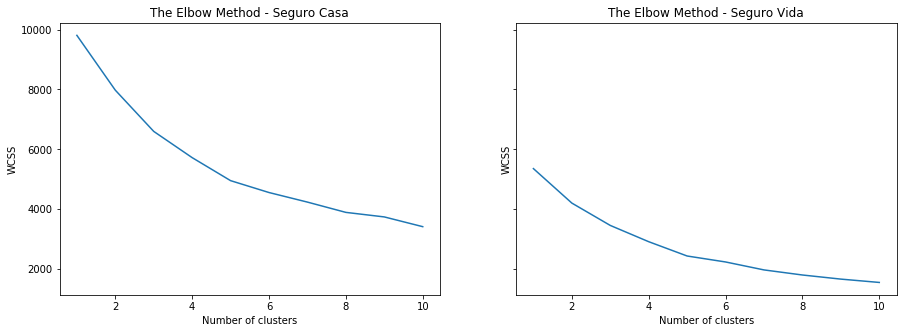

In [32]:
# Normalizando os dados
sc_casa = StandardScaler().fit(train_casa)
train_casa = sc_casa.transform(train_casa)
sc_vida = StandardScaler().fit(train_vida)
train_vida = sc_vida.transform(train_vida)


# Using the elbow method to find the optimal number of clusters
# Seguro de Casa:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),sharey=True)
wcss_casa = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(train_casa)
    wcss_casa.append(kmeans.inertia_)
ax1.plot(range(1, 11), wcss_casa)
ax1.set_title('The Elbow Method - Seguro Casa')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS')

#Seguro de Vida:
wcss_vida = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(train_vida)
    wcss_vida.append(kmeans.inertia_)
ax2.plot(range(1, 11), wcss_vida)
ax2.set_title('The Elbow Method - Seguro Vida')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('WCSS')
plt.show()

### Seguro de casa:

In [33]:
# Fitting K-Means to the dataset
# Seguro de casa:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 0)
resultado = kmeans.fit_predict(train_casa)
grupos = pd.DataFrame(data=resultado, columns = {'Grupo': '0'})
train_casa = sc_casa.inverse_transform(train_casa)
train_casa = pd.DataFrame(data=train_casa, columns=list(train_presta.columns))
train_casa = train_casa.join(grupos)
#train_casa.Idade = train_casa.Idade.astype(int)
train_casa.ValorSEG = train_casa.ValorSEG * 12

print('Correlação das variáveis:\n',train_casa.corr().Grupo,'\n')
print('Total de pessoas por grupo:\n',train_casa.Grupo.value_counts(),'\n')
print('Valores médios por grupo:\n',train_casa.groupby('Grupo').mean(),'\n')
print('Valores medianos por grupo:\n',train_casa.groupby('Grupo').median(),'\n')
print('Erro de desvio por grupo:\n',train_casa.groupby('Grupo').std(),'\n')
# perfil_casa_medio = train_casa.groupby('Grupo').mean()
# total_casa = train_casa.Grupo.value_counts()
# perfil_casa_medio['TotalSEG'] = total_casa
# perfil_casa_medio['Valor_Total'] = perfil_casa_medio['TotalSEG'] * perfil_casa_medio['ValorSEG']
# perfil_casa_erro = train_casa.groupby('Grupo').std()

Correlação das variáveis:
 ValorSEG     -0.378749
GrupoRenda    0.106838
GrupoIdade    0.163631
Distancia    -0.508013
Grupo         1.000000
Name: Grupo, dtype: float64 

Total de pessoas por grupo:
 3    669
2    560
4    548
1    386
0    289
Name: Grupo, dtype: int64 

Valores médios por grupo:
          ValorSEG  GrupoRenda  GrupoIdade     Distancia
Grupo                                                  
0      252.230450    3.643599    1.854671  61242.525952
1      565.084352    4.194301    1.637306  21460.599046
2      249.665357    2.535714    0.682143  25575.662518
3      226.434798    2.550075    2.469357  18992.917513
4      203.573212    4.739051    1.706204  18188.377748 

Valores medianos por grupo:
        ValorSEG  GrupoRenda  GrupoIdade  Distancia
Grupo                                             
0        231.48         4.0         2.0    57945.0
1        494.52         4.0         2.0    18035.5
2        267.96         2.5         1.0    29327.0
3        197.04      

### Seguro de vida:

In [34]:
# Fitting K-Means to the dataset
# Seguro de vida:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 0)
resultado = kmeans.fit_predict(train_vida)
grupos = pd.DataFrame(data=resultado, columns = {'Grupo': '0'})
train_vida = sc_vida.inverse_transform(train_vida)
train_vida = pd.DataFrame(data=train_vida, columns=list(train_presta.columns))
train_vida = train_vida.join(grupos)
#train_vida.Idade = train_vida.Idade.astype(int)

print('Correlação das variáveis:\n',train_vida.corr().Grupo,'\n')
print('Total de pessoas por grupo:\n',train_vida.Grupo.value_counts(),'\n')
print('Valores médios por grupo:\n',train_vida.groupby('Grupo').mean(),'\n')
print('Valores medianos por grupo:\n',train_vida.groupby('Grupo').median(),'\n')
print('Erro de desvio por grupo:\n',train_vida.groupby('Grupo').std(),'\n')
# perfil_vida_medio = train_vida.groupby('Grupo').mean()
# total_vida = train_vida.Grupo.value_counts()
# perfil_vida_medio['TotalSEG'] = total_vida
# perfil_vida_medio['Valor_Total'] = perfil_vida_medio['TotalSEG'] * perfil_vida_medio['ValorSEG']
# perfil_vida_erro = train_vida.groupby('Grupo').std()

Correlação das variáveis:
 ValorSEG      0.350808
GrupoRenda    0.429123
GrupoIdade   -0.237670
Distancia     0.445529
Grupo         1.000000
Name: Grupo, dtype: float64 

Total de pessoas por grupo:
 1    623
0    246
2    243
3    188
4     39
Name: Grupo, dtype: int64 

Valores médios por grupo:
         ValorSEG  GrupoRenda  GrupoIdade     Distancia
Grupo                                                 
0      14.887805    2.304878    2.199187  24759.916615
1      14.330369    2.319422    0.402889  21687.511019
2      16.090658    4.465021    1.621399  23271.567779
3      14.885266    2.851064    0.680851  65858.994681
4      67.266154    3.743590    0.743590  36223.631126 

Valores medianos por grupo:
        ValorSEG  GrupoRenda  GrupoIdade    Distancia
Grupo                                               
0         14.16         2.0         2.0  25776.50000
1         14.16         2.0         0.0  22590.00000
2         14.16         4.0         2.0  19560.00000
3         14.16   